In [1]:
%sh
/databricks/python/bin/pip install molsets
find /databricks/python/lib/python3.6/site-packages/moses/ -type f -print0 | xargs -0 sed -i 's/from\ rdkit.six.moves\ import\ cPickle/import\ _pickle\ as\ cPickle/g'

Collecting molsets
 Downloading https://files.pythonhosted.org/packages/d2/69/07e97e29998f9a0ef43ae3f9767faaaeec0c1e3b92796a57185574d4ef03/molsets-0.1.3-py3-none-any.whl (6.0MB)
Collecting fcd-torch>=1.0.5 (from molsets)
 Downloading https://files.pythonhosted.org/packages/48/45/476df503cd87d28486af12c37b2e71fc5d0b2730f9bd0539cf19782678b8/fcd_torch-1.0.7-py3-none-any.whl (5.2MB)
Requirement already satisfied: pandas>=0.23 in /databricks/python3/lib/python3.6/site-packages (from molsets) (0.23.0)
Collecting torch>=1.0.1 (from molsets)
 Downloading https://files.pythonhosted.org/packages/69/60/f685fb2cfb3088736bafbc9bdbb455327bdc8906b606da9c9a81bae1c81e/torch-1.1.0-cp36-cp36m-manylinux1_x86_64.whl (676.9MB)
Requirement already satisfied: tqdm>=4.26.0 in /databricks/python3/lib/python3.6/site-packages (from molsets) (4.31.1)
Requirement already satisfied: seaborn in /databricks/python3/lib/python3.6/site-packages (from molsets) (0.9.0)
Requirement already satisfied: numpy>=1.15 in /databricks/python3/lib/python3.6/site-packages (from molsets) (1.16.0)
Requirement already satisfied: matplotlib>=3.0.0 in /databricks/python3/lib/python3.6/site-packages (from molsets) (3.0.3)
Requirement already satisfied: scipy>=1.1.0 in /databricks/python3/lib/python3.6/site-packages (from molsets) (1.1.0)
Requirement already satisfied: python-dateutil>=2.5.0 in /databricks/python3/lib/python3.6/site-packages (from pandas>=0.23->molsets) (2.7.3)
Requirement already satisfied: pytz>=2011k in /databricks/python3/lib/python3.6/site-packages (from pandas>=0.23->molsets) (2018.4)
Requirement already satisfied: cycler>=0.10 in /databricks/python3/lib/python3.6/site-packages (from matplotlib>=3.0.0->molsets) (0.10.0)
Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /databricks/python3/lib/python3.6/site-packages (from matplotlib>=3.0.0->molsets) (2.2.0)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.6/site-packages (from matplotlib>=3.0.0->molsets) (1.1.0)
Requirement already satisfied: six>=1.5 in /databricks/python3/lib/python3.6/site-packages (from python-dateutil>=2.5.0->pandas>=0.23->molsets) (1.11.0)
Requirement already satisfied: setuptools in /databricks/python3/lib/python3.6/site-packages (from kiwisolver>=1.0.1->matplotlib>=3.0.0->molsets) (39.1.0)
Installing collected packages: torch, fcd-torch, molsets
 Found existing installation: torch 0.4.1
 Uninstalling torch-0.4.1:
 Successfully uninstalled torch-0.4.1
Successfully installed fcd-torch-1.0.7 molsets-0.1.3 torch-1.1.0
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [2]:
import argparse
#import six.cPickle as cPickle
import os
import sys
import torch
import rdkit
import numpy as np
#import warnings
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import moses
from moses.script_utils import add_train_args, read_smiles_csv, set_seed, add_sample_args
from moses.models_storage import ModelsStorage
from moses.metrics.metrics import get_all_metrics
from tqdm import tqdm
from moses.metrics import FrechetMetric, NP, weight, logP, SA, QED
from moses.metrics.utils import get_mol, mapper
from moses.utils import disable_rdkit_log


In [3]:
datasets = ["Homopiperazines","Piperazines","Piperidines","Sulphamides"]
names = ["JAK1 EC50 nM 1027","JAK2 EC50 nM 1024","JAK3 EC50 nM 1026"]
names = names + ['TYK2 EC50 nM 1025']
files = ["/dbfs/FileStore/tables/Homopiperazines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Piperazines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Piperidines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Sulphamides_cleaned_Feb_2019.sdf",
        ]
PARENT_DIR = '/dbfs/FileStore/tables'
PICKLES_DIR = '/dbfs/FileStore/pickles'
MOSES_DIR = '/dbfs/FileStore/moses'
CHEMPROP_DIR = '/dbfs/FileStore/chemprop'


In [4]:
MODELS = ModelsStorage()

In [5]:
y_train = {}
y_test = {}
full_internal = pd.read_csv(os.path.join(PARENT_DIR,'full_smiles.txt'), header=None).rename(columns={0:'SMILES'})
X_train = pd.read_csv(os.path.join(PARENT_DIR,'X_train_smiles.txt'), header=None, squeeze=True).astype(str).tolist()
X_test = pd.read_csv(os.path.join(PARENT_DIR,'X_test_smiles.txt'), header=None, squeeze=True).astype(str).tolist()
for name in names:
  #full_internal[name]=pd.read_csv(os.path.join(PARENT_DIR,name+'-full.txt'), header=None,index=False)
  y_train[name]=pd.read_csv(os.path.join(PARENT_DIR,name+'-y_train.txt'), header=None, squeeze=True).astype(float).tolist()
  y_test[name]=pd.read_csv(os.path.join(PARENT_DIR,name+'-y_test.txt'), header=None, squeeze=True).astype(float).tolist()

In [6]:
pd.DataFrame({'SMILES':X_train}).to_csv(os.path.join(MOSES_DIR,'X_train_smiles.txt'),index=False)

In [7]:
pd.DataFrame({'SMILES':X_test}).to_csv(os.path.join(MOSES_DIR,'X_test_smiles.txt'),index=False)

In [8]:
pd.DataFrame({'SMILES':X_test})['SMILES'].str.contains('@').any()

Out[10]: True

# Training

In [10]:
def parser_train():
    parser = argparse.ArgumentParser()
    subparsers = parser.add_subparsers(
        title='Models trainer script', description='available models'
    )
    for model in MODELS.get_model_names():
        add_train_args(
            MODELS.get_model_train_parser(model)(
                subparsers.add_parser(model)
            )
        )
    return parser

In [11]:
def train(model, config):
    set_seed(config.seed)
    device = torch.device(config.device)

    if config.config_save is not None:
        torch.save(config, config.config_save)

    # For CUDNN to work properly
    if device.type.startswith('cuda'):
        torch.cuda.set_device(device.index or 0)

    train_data = read_smiles_csv(config.train_load)
    if config.val_load:
        val_data = read_smiles_csv(config.val_load)
    else:
        val_data = None
    trainer = MODELS.get_model_trainer(model)(config)

    if config.vocab_load is not None:
        assert os.path.exists(config.vocab_load), \
            'vocab_load path does not exist!'
        vocab = torch.load(config.vocab_load)
    else:
        vocab = trainer.get_vocabulary(train_data)

    if config.vocab_save is not None:
        torch.save(vocab, config.vocab_save)

    model = MODELS.get_model_class(model)(vocab, config).to(device)
    trainer.fit(model, train_data, val_data)

    model = model.to('cpu')
    torch.save(model.state_dict(), config.model_save)

In [12]:

parser = parser_train()
conf = parser.parse_args(['organ','--help'])[0]
train('organ',conf)

An exception has occurred, use %tb to see the full traceback.

 SystemExit : 0

### Pre-training with 90% id sample ZINC

In [14]:
pd.read_csv('/dbfs/FileStore/ZINC/13t09_filt.txt', header=None).rename(columns = {0:'SMILES'}).to_csv('/dbfs/FileStore/ZINC/13t09_filt.SMILES',index=False)

In [15]:
%sh wc /dbfs/FileStore/ZINC/13t09_filt.txt

53585 53585 1460717 /dbfs/FileStore/ZINC/13t09_filt.txt

In [16]:
ZINC_Models = os.path.join('/dbfs/FileStore/ZINC','models')
if not os.path.exists(ZINC_Models):
    os.makedirs(ZINC_Models)
MODELS = ModelsStorage()
parser = parser_train()
config = parser.parse_args(['aae',
                            '--seed', '13',
                            '--train_load','/dbfs/FileStore/ZINC/13t09_filt.SMILES',
                            #'--val_load',os.path.join(MOSES_DIR,'X_test_smiles.txt'),
                            '--model_save',os.path.join(ZINC_Models,'aae-13t09-filt.model'),
                            '--config_save',os.path.join(ZINC_Models,'aae-13t09-filt.config'),
                            '--vocab_save',os.path.join(ZINC_Models,'aae-13t09-filt.vocab'),
                            '--log_file',os.path.join(ZINC_Models,'aae-13t09-.log')])
train('aae',config)
config = parser.parse_args(['char_rnn',
                            '--seed', '13',
                            '--train_load','/dbfs/FileStore/ZINC/13t09_filt.SMILES',
                            #'--val_load',os.path.join(MOSES_DIR,'X_test_smiles.txt'),
                            '--model_save',os.path.join(ZINC_Models,'char_rnn-13t09-filt.model'),
                            '--config_save',os.path.join(ZINC_Models,'char_rnn-13t09-filt.config'),
                            '--vocab_save',os.path.join(ZINC_Models,'char_rnn-13t09-filt.vocab'),
                            '--log_file',os.path.join(ZINC_Models,'char_rnn-13t09-filt.log')])
train('char_rnn',config)

Training (epoch #0): 0%| | 0/419 [00:00<?, ?it/s]Training (epoch #0): 0%| | 0/419 [00:00<?, ?it/s, autoencoder_loss=3.42, generator_loss=0.669, discriminator_loss=0.674]Training (epoch #0): 0%| | 0/419 [00:00<?, ?it/s, autoencoder_loss=3.39, generator_loss=0.555, discriminator_loss=0.853]Training (epoch #0): 0%| | 2/419 [00:00<00:34, 12.00it/s, autoencoder_loss=3.39, generator_loss=0.555, discriminator_loss=0.853]Training (epoch #0): 0%| | 2/419 [00:00<00:34, 12.00it/s, autoencoder_loss=3.35, generator_loss=0.607, discriminator_loss=0.72] Training (epoch #0): 0%| | 2/419 [00:00<00:34, 12.00it/s, autoencoder_loss=3.29, generator_loss=0.708, discriminator_loss=0.654]Training (epoch #0): 1%| | 4/419 [00:00<00:36, 11.50it/s, autoencoder_loss=3.29, generator_loss=0.708, discriminator_loss=0.654]Training (epoch #0): 1%| | 4/419 [00:00<00:36, 11.50it/s, autoencoder_loss=3.21, generator_loss=0.888, discriminator_loss=0.617]Training (epoch #0): 1%| | 4/419 [00:00<00:36, 11.50it/s, autoencoder_loss=3.13, generator_loss=1.08, discriminator_loss=0.538] Training (epoch #0): 1%|▏ | 6/419 [00:00<00:33, 12.18it/s, autoencoder_loss=3.13, generator_loss=1.08, discriminator_loss=0.538]Training (epoch #0): 1%|▏ | 6/419 [00:00<00:33, 12.18it/s, autoencoder_loss=3.07, generator_loss=1.31, discriminator_loss=0.531]Training (epoch #0): 1%|▏ | 6/419 [00:00<00:33, 12.18it/s, autoencoder_loss=3.02, generator_loss=1.53, discriminator_loss=0.47] Training (epoch #0): 2%|▏ | 8/419 [00:00<00:32, 12.66it/s, autoencoder_loss=3.02, generator_loss=1.53, discriminator_loss=0.47]Training (epoch #0): 2%|▏ | 8/419 [00:00<00:32, 12.66it/s, autoencoder_loss=2.98, generator_loss=1.76, discriminator_loss=0.466]Training (epoch #0): 2%|▏ | 8/419 [00:00<00:32, 12.66it/s, autoencoder_loss=2.94, generator_loss=1.98, discriminator_loss=0.422]Training (epoch #0): 2%|▏ | 10/419 [00:00<00:31, 12.97it/s, autoencoder_loss=2.94, generator_loss=1.98, discriminator_loss=0.422]Training (epoch #0): 2%|▏ | 10/419 [00:00<00:31, 12.97it/s, autoencoder_loss=2.9, generator_loss=2.2, discriminator_loss=0.424] Training (epoch #0): 2%|▏ | 10/419 [00:00<00:31, 12.97it/s, autoencoder_loss=2.87, generator_loss=2.39, discriminator_loss=0.39]Training (epoch #0): 3%|▎ | 12/419 [00:00<00:30, 13.31it/s, autoencoder_loss=2.87, generator_loss=2.39, discriminator_loss=0.39]Training (epoch #0): 3%|▎ | 12/419 [00:00<00:30, 13.31it/s, autoencoder_loss=2.84, generator_loss=2.57, discriminator_loss=0.391]Training (epoch #0): 3%|▎ | 12/419 [00:01<00:30, 13.31it/s, autoencoder_loss=2.82, generator_loss=2.7, discriminator_loss=0.364] Training (epoch #0): 3%|▎ | 14/419 [00:01<00:29, 13.55it/s, autoencoder_loss=2.82, generator_loss=2.7, discriminator_loss=0.364]Training (epoch #0): 3%|▎ | 14/419 [00:01<00:29, 13.55it/s, autoencoder_loss=2.8, generator_loss=2.79, discriminator_loss=0.359]Training (epoch #0): 3%|▎ | 14/419 [00:01<00:29, 13.55it/s, autoencoder_loss=2.77, generator_loss=2.84, discriminator_loss=0.339]Training (epoch #0): 4%|▍ | 16/419 [00:01<00:29, 13.79it/s, autoencoder_loss=2.77, generator_loss=2.84, discriminator_loss=0.339]Training (epoch #0): 4%|▍ | 16/419 [00:01<00:29, 13.79it/s, autoencoder_loss=2.75, generator_loss=2.85, discriminator_loss=0.335]Training (epoch #0): 4%|▍ | 16/419 [00:01<00:29, 13.79it/s, autoencoder_loss=2.73, generator_loss=2.81, discriminator_loss=0.342]Training (epoch #0): 4%|▍ | 18/419 [00:01<00:28, 13.93it/s, autoencoder_loss=2.73, generator_loss=2.81, discriminator_loss=0.342]Training (epoch #0): 4%|▍ | 18/419 [00:01<00:28, 13.93it/s, autoencoder_loss=2.71, generator_loss=2.76, discriminator_loss=0.337]Training (epoch #0): 4%|▍ | 18/419 [00:01<00:28, 13.93it/s, autoencoder_loss=2.69, generator_loss=2.72, discriminator_loss=0.37] Training (epoch #0): 5%|▍ | 20/419 [00:01<00:28, 13.98it/s, autoencoder_loss=2.69, generator_loss=2.72, discriminator_loss=0.37]Training (epoch #0): 5%|▍ | 20/419 [00:01<00:28, 13.98it/s, autoencoder_loss=2.67, gene

# Loss

In [18]:
logcsv = pd.read_csv(os.path.join(MOSES_DIR,'aae.log'))

In [19]:
aa_tr = logcsv[logcsv['mode']=='Train']['autoencoder_loss']
aa_tr.name = 'Autoencoder Train Loss'
dis_tr = logcsv[logcsv['mode']=='Train']['discriminator_loss']
dis_tr.name = 'Discriminator Train Loss'
gen_tr = logcsv[logcsv['mode']=='Train']['generator_loss']
gen_tr.name = 'Generator Train Loss'
aa_ev = logcsv[logcsv['mode']=='Eval']['autoencoder_loss']
aa_ev.name = 'Autoencoder Validation Loss'
dis_ev = logcsv[logcsv['mode']=='Eval']['discriminator_loss']
dis_ev.name = 'Discriminator Validation Loss'
gen_ev = logcsv[logcsv['mode']=='Eval']['generator_loss']
gen_ev.name = 'Generator Validation Loss'

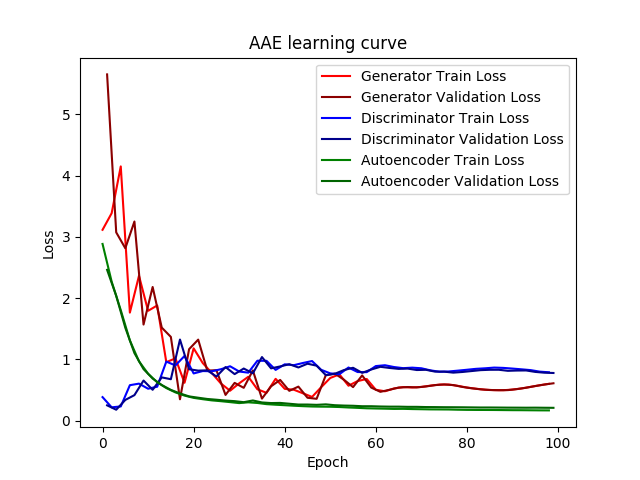

In [20]:
plt.close()
plt.plot(gen_tr,c='red')
plt.plot(gen_ev,c='darkred')
plt.plot(dis_tr,c='blue')
plt.plot(dis_ev,c='darkblue')
plt.plot(aa_tr,c='green')
plt.plot(aa_ev,c='darkgreen')
plt.legend()
plt.title('AAE learning curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
display(plt.show())

In [21]:
logcsv = pd.read_csv(os.path.join(MOSES_DIR,'char_rnn.log'))
logcsv.head()

Out[85]: 
 loss mode running_loss
0 2.712139 Train 2.975419
1 2.681660 Eval 2.687555
2 2.235720 Train 2.478627
3 2.150329 Eval 2.181552
4 1.580051 Train 1.909334

In [22]:
l_tr = logcsv[logcsv['mode']=='Train']['loss']
l_tr.name = 'Train Loss'
rl_tr = logcsv[logcsv['mode']=='Train']['running_loss']
rl_tr.name = 'Running Train Loss'

l_ev = logcsv[logcsv['mode']=='Eval']['loss']
l_ev.name = 'Validation Loss'
rl_ev = logcsv[logcsv['mode']=='Eval']['running_loss']
rl_ev.name = 'Running Validation Loss'


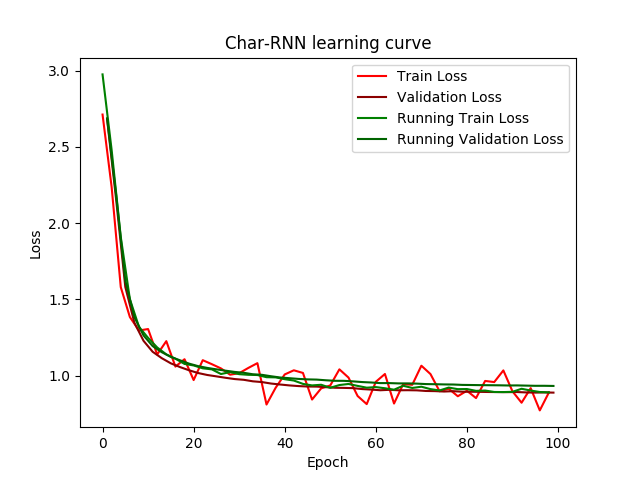

In [23]:
plt.close()
plt.plot(l_tr,c='red')
plt.plot(l_ev,c='darkred')
plt.plot(rl_tr,c='green')
plt.plot(rl_ev,c='darkgreen')
plt.legend()
plt.title('Char-RNN learning curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
display(plt.show())

In [24]:
import pandas as pd
jtnn_loss = pd.read_csv('/dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_log-13t09_filt.csv')
display(jtnn_loss.head())

loss,kl_div,wacc,tacc,sacc,dacc,word_acc,topo_acc,assm_acc,steo_acc
"tensor(229.0251, device='cuda:0', grad_fn=)",3168.447998046875,0.4850393533706665,0.8991869688034058,0.7522522522522522,1.0,0.4850393533706665,0.8991869688034058,0.7522522522522522,1.0
"tensor(146.3879, device='cuda:0', grad_fn=)",3147.814697265625,0.5460317730903625,0.9172131419181824,0.8357487922705314,1.0,1.031071126461029,1.816400110721588,1.5880010445227837,2.0
"tensor(129.5241, device='cuda:0', grad_fn=)",3067.09716796875,0.5500795245170593,0.923645317554474,0.9120370370370372,1.0,1.5811506509780884,2.740045428276062,2.5000380815598207,3.0
"tensor(120.5844, device='cuda:0', grad_fn=)",3266.92529296875,0.5729984641075134,0.8962723016738892,0.8798076923076923,1.0,2.154149115085602,3.636317729949951,3.3798457738675127,4.0
"tensor(96.5699, device='cuda:0', grad_fn=)",3038.096435546875,0.6199678182601929,0.9301164150238036,0.932367149758454,1.0,2.7741169333457947,4.566434144973755,4.312212923625967,5.0


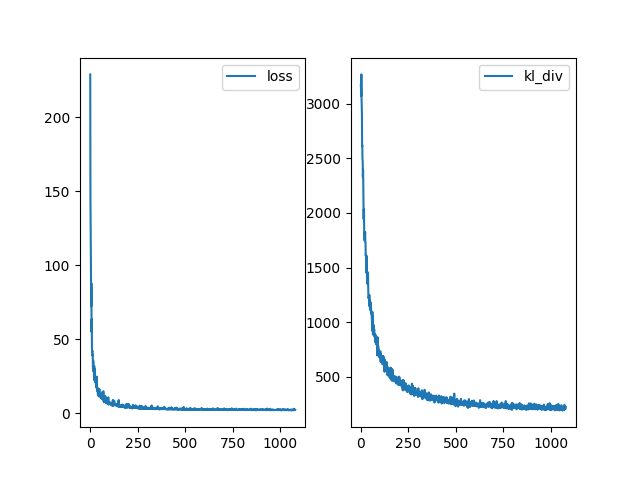

In [25]:
import os
jtnn_loss = pd.read_csv('/dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_log-13t09_filt.csv')
jtnn_loss['loss'] = [float(''.join(re.findall("\d+\.\d+", item))) for item in jtnn_loss['loss']]
plt.close()
plt.subplot(121)
plt.plot(jtnn_loss.loss, label = 'loss')
plt.legend()
plt.subplot(122)
plt.plot(jtnn_loss.kl_div, label = 'kl_div')
plt.legend()
display(plt.show()) #KL USUALLY GOING UP

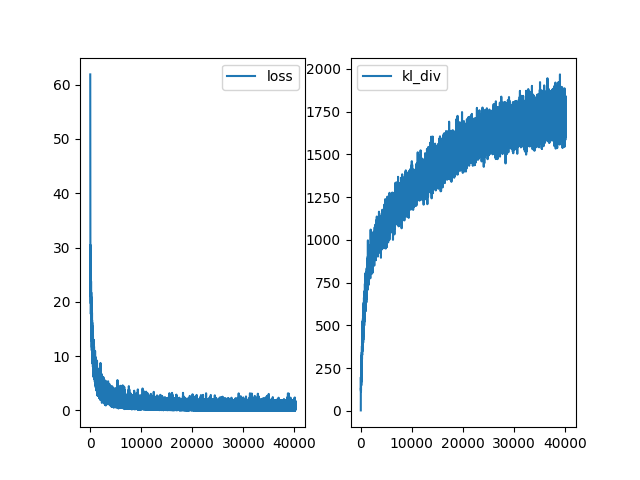

In [26]:
import os
jtnn_loss = pd.read_csv('/dbfs/FileStore/pickles/jtvae_model/13t09_filt/pretrain_log-13t09_filt.csv')
jtnn_loss['loss'] = [float(''.join(re.findall("\d+\.\d+", item))) for item in jtnn_loss['loss']]
plt.close()
plt.subplot(121)
plt.plot(jtnn_loss.loss, label = 'loss')
plt.legend()
plt.subplot(122)
plt.plot(jtnn_loss.kl_div, label = 'kl_div')
plt.legend()
display(plt.show())

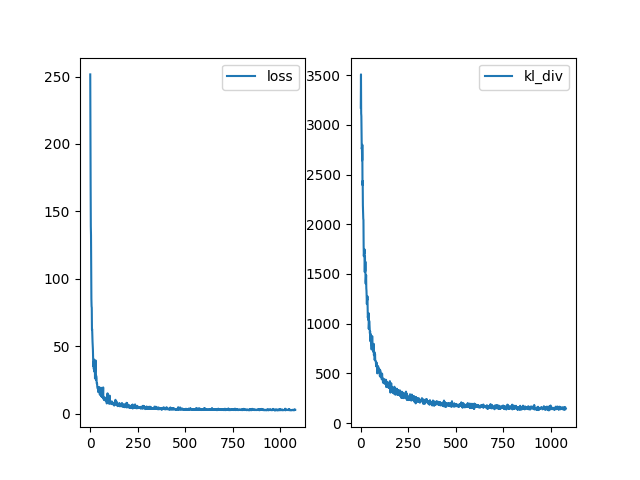

In [27]:
MODEL_DIR = os.path.join(PICKLES_DIR, "jtvae_model")
import re
weight_dir = os.path.join(MODEL_DIR,'13t09_filt')

save_dir = os.path.join(weight_dir,'focused_b001')
out_file = os.path.join(save_dir,'vae_log-13t09_filt.csv')
jtnn_loss = pd.read_csv(out_file)
jtnn_loss['loss'] = [float(''.join(re.findall("\d+\.\d+", item))) for item in jtnn_loss['loss']]
plt.close()
plt.subplot(121)
plt.plot(jtnn_loss.loss, label = 'loss')
plt.legend()
plt.subplot(122)
plt.plot(jtnn_loss.kl_div, label = 'kl_div')
plt.legend()
display(plt.show())

# Generation

In [29]:

def parser_generate():
    parser = argparse.ArgumentParser()
    subparsers = parser.add_subparsers(
        title='Models sampler script', description='available models')
    for model in MODELS.get_model_names():
        add_sample_args(subparsers.add_parser(model))
    return parser


def generate(model, config):
    set_seed(config.seed)
    device = torch.device(config.device)

    # For CUDNN to work properly:
    if device.type.startswith('cuda'):
        torch.cuda.set_device(device.index or 0)

    model_config = torch.load(config.config_load)
    model_vocab = torch.load(config.vocab_load)
    model_state = torch.load(config.model_load)

    model = MODELS.get_model_class(model)(model_vocab, model_config)
    model.load_state_dict(model_state)
    model = model.to(device)
    model.eval()

    samples = []
    n = config.n_samples
    with tqdm(total=config.n_samples, desc='Generating samples') as T:
        while n > 0:
            current_samples = model.sample(
                min(n, config.n_batch), config.max_len
            )
            samples.extend(current_samples)

            n -= len(current_samples)
            T.update(len(current_samples))

    samples = pd.DataFrame(samples, columns=['SMILES'])
    samples.to_csv(config.gen_save, index=False)

In [30]:

MODELS = ModelsStorage()
parser = parser_generate()
config = parser.parse_known_args(['organ','--help'])[0]
generate(config)

An exception has occurred, use %tb to see the full traceback.

 SystemExit : 0

In [31]:
MODELS.get_model_names()

Out[141]: ['aae', 'char_rnn', 'vae', 'organ']

In [32]:
MODELS = ModelsStorage()
parser = parser_generate()
config = parser.parse_args(['aae','--model_load',os.path.join(MOSES_DIR,'aae.model'),
                            '--config_load',os.path.join(MOSES_DIR,'aae.config'),
                            '--vocab_load',os.path.join(MOSES_DIR,'aae.vocab'),
                            '--n_samples','500',
                            '--gen_save',os.path.join(MOSES_DIR,'aae_generated.smi')])
# config = argparse.Namespace(model_load=os.path.join(MOSES_DIR,'aae.model'),
#                             config_load=os.path.join(MOSES_DIR,'aae.config'),
#                             vocab_load=os.path.join(MOSES_DIR,'aae.vocab'),
#                             n_samples = 500,
#                             gen_save=os.path.join(MOSES_DIR,'aae_generated.smi'))
model='aae'
generate(model,config)

Generating samples: 0%| | 0/500 [00:00<?, ?it/s]Generating samples: 6%|▋ | 32/500 [00:00<00:01, 261.30it/s]Generating samples: 13%|█▎ | 64/500 [00:00<00:01, 263.06it/s]Generating samples: 19%|█▉ | 96/500 [00:00<00:01, 263.62it/s]Generating samples: 26%|██▌ | 128/500 [00:00<00:01, 263.37it/s]Generating samples: 32%|███▏ | 160/500 [00:00<00:01, 263.48it/s]Generating samples: 38%|███▊ | 192/500 [00:00<00:01, 264.71it/s]Generating samples: 45%|████▍ | 224/500 [00:00<00:01, 264.54it/s]Generating samples: 51%|█████ | 256/500 [00:00<00:00, 265.06it/s]Generating samples: 58%|█████▊ | 288/500 [00:01<00:00, 266.08it/s]Generating samples: 64%|██████▍ | 320/500 [00:01<00:00, 266.67it/s]Generating samples: 70%|███████ | 352/500 [00:01<00:00, 265.74it/s]Generating samples: 77%|███████▋ | 384/500 [00:01<00:00, 266.26it/s]Generating samples: 83%|████████▎ | 416/500 [00:01<00:00, 266.53it/s]Generating samples: 90%|████████▉ | 448/500 [00:01<00:00, 266.13it/s]Generating samples: 96%|█████████▌| 480/500 [00:01<00:00, 266.79it/s]Generating samples: 100%|██████████| 500/500 [00:01<00:00, 259.71it/s]

# Evaluation

In [34]:

def evaluate(config, print_metrics=True):
    test = read_smiles_csv(config.test_path)
    test_scaffolds = None
    ptest = None
    ptest_scaffolds = None
    if config.test_scaffolds_path is not None:
        test_scaffolds = read_smiles_csv(config.test_scaffolds_path)
    gen = read_smiles_csv(config.gen_path)
    metrics = get_all_metrics(test, gen, k=config.ks, n_jobs=config.n_jobs,
                              device=config.device,
                              test_scaffolds=test_scaffolds,
                              ptest=ptest, ptest_scaffolds=ptest_scaffolds)

    if print_metrics:
        for name, value in metrics.items():
            print('{},{}'.format(name, value))
    else:
        return metrics


def parser_eval():
    parser = argparse.ArgumentParser()
    parser.add_argument('--test_path',
                        type=str, required=True,
                        help='Path to test molecules csv')
    parser.add_argument('--test_scaffolds_path',
                        type=str, required=False,
                        help='Path to scaffold test molecules csv')
    parser.add_argument('--gen_path',
                        type=str, required=True,
                        help='Path to generated molecules csv')
    parser.add_argument('--ks',
                        nargs='+', default=[1000, 10000],
                        help='Prefixes to calc uniqueness at')
    parser.add_argument('--n_jobs',
                        type=int, default=1,
                        help='Number of processes to run metrics')
    parser.add_argument('--device',
                        type=str, default='cpu',
                        help='GPU device id (`cpu` or `cuda:n`)')

    return parser

In [35]:
parser = parser_eval()
config = parser.parse_known_args(['-h'])[0]
evaluate(config)

An exception has occurred, use %tb to see the full traceback.

 SystemExit : 0

In [36]:
config = parser.parse_known_args(['--test_path',os.path.join(MOSES_DIR,'X_test_smiles.txt'),
                                  '--gen_path',os.path.join(MOSES_DIR,'aae_generated.smi')])[0]
# config = argparse.Namespace(test_path=os.path.join(MOSES_DIR,'X_test_smiles.txt'),
#                             gen_path=os.path.join(MOSES_DIR,'aae_generated.smi'),
#                             test_scaffolds_path=None,
#                             ks = [1000, 10000],
#                             n_jobs=4)
metrics = evaluate(config, print_metrics = False)

--------------------------------------------------------------------------- 
 AttributeError Traceback (most recent call last)
 <command-4164146939805615> in <module> () 
 6 ks = [ 1000 , 10000 ] , 
 7 n_jobs=4)
 ----> 8 metrics = main_eval ( config , print_metrics = False ) 

 <command-4164146939805617> in main_eval (config, print_metrics) 
 9 gen = read_smiles_csv ( config . gen_path ) 
 10 metrics = get_all_metrics(test, gen, k=config.ks, n_jobs=config.n_jobs,
 ---> 11 device = config . device , 
 12 test_scaffolds = test_scaffolds , 
 13 ptest=ptest, ptest_scaffolds=ptest_scaffolds)

 AttributeError : 'Namespace' object has no attribute 'device'

In [37]:
metrics_df = pd.DataFrame(list(metrics.values())).T
metrics_df.columns = list(metrics.keys())
display(metrics_df)

valid,unique@1000,unique@10000,FCD/Test,SNN/Test,Frag/Test,Scaf/Test,IntDiv,IntDiv2,Filters,logP,SA,QED,NP,weight
0.6659999999999999,0.5405405405405406,0.5405405405405406,4.02984696095772,0.7792999196696926,0.9514561059994654,0.49119144119314784,0.5181502854877065,0.5041489110391626,0.978978978978979,0.050425214908543126,0.04064230836971339,3.873722834298529E-4,0.007518154648050224,55.15771842902177


# Descriptor value distributions

In [39]:

def plot_distributions(models, test, metrics = {'NP': NP,'weight': weight,'logP': logP,'SA': SA,'QED': QED}, n_jobs = 4, img_folder=None):
    
    if img_folder:
        os.makedirs(img_folder, exist_ok=True)

    generated = OrderedDict({'Test': pd.read_csv(test)})
    for path, name in zip(models['path'], models['name']):
        generated[name] = pd.read_csv(path)

    fig, axes = plt.subplots(1, len(metrics)
                             #, sharex = True, sharey=True
                             #, squeeze=False
                             ,figsize=(len(metrics)*6,6)
                            )

    for s in generated.values():
        s['ROMol'] = mapper(n_jobs)(get_mol, s['SMILES'])

    distributions = OrderedDict()
    for metric_name, metric_fn in metrics.items():
        distributions[metric_name] = OrderedDict()
        for _set, _molecules in generated.items():
            distributions[metric_name][_set] = mapper(n_jobs)(
                metric_fn, _molecules['ROMol'].dropna().values
            )
    print(len(metrics))
    print(len(distributions))
    for metric_i, metric_name in enumerate(metrics):
      
        for model, d in distributions[metric_name].items():
            print(axes.shape)
            ax=axes[metric_i]
            dist = FrechetMetric()(distributions[metric_name]['Test'], d)
            sns.distplot(
                d, hist=False, kde=True,
                kde_kws={'shade': True, 'linewidth': 3},
                #label='{0} ({1:0.2g})'.format(model, dist),
                ax=ax)
            ax.set_title(metric_name, fontsize=14)
            ax.set_yticklabels([])
            #g._legend.remove()#plt.setp(ax.get_legend().get_texts(), fontsize='22')
        if img_folder:
            plt.savefig(
                os.path.join(img_folder, metric_name+'.pdf')
            )
            plt.savefig(
                os.path.join(img_folder, metric_name+'.png'),
                dpi=250
            )
    #sns.set(font_scale = 2)
    return fig

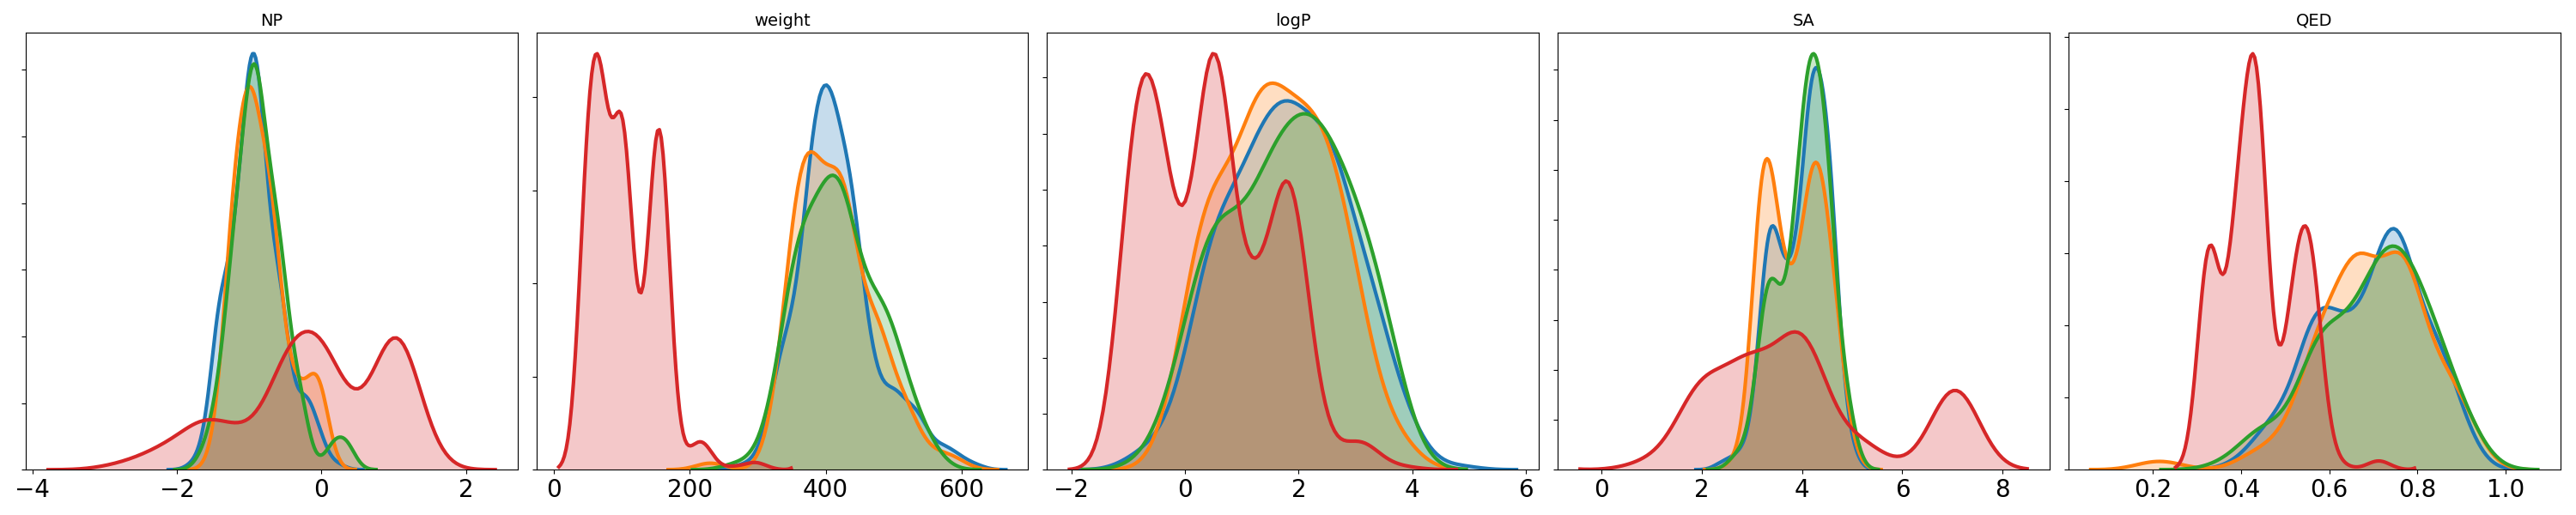

In [40]:
names = ['aae','char_rnn']#,'vae'
models = pd.DataFrame({'path':[os.path.join(MOSES_DIR,name+'_generated.smi') for name in names],
                       'name':[name.upper() for name in names]})
model_jtnn = pd.DataFrame({'path':[os.path.join(MOSES_DIR,'JT_VAE_generated.txt')],
                          'name':['JTNN_VAE']})
models = pd.concat([models, model_jtnn], axis =0).reset_index()
fig = plot_distributions(models=models, test=os.path.join(MOSES_DIR,'X_test_smiles.txt'))
fig.tight_layout()
display(fig)

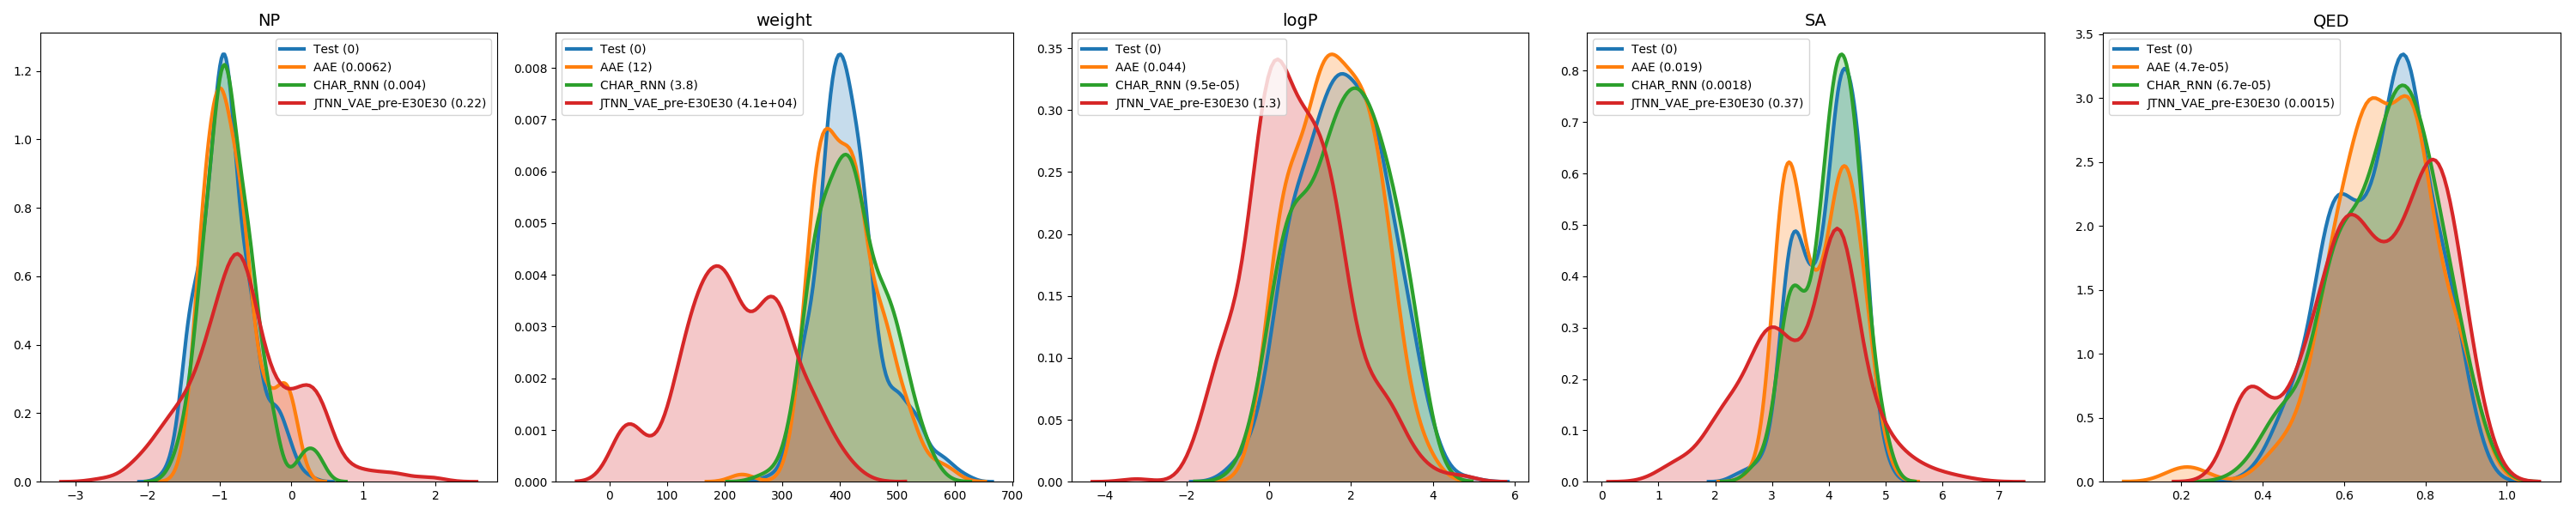

In [41]:
names = ['aae','char_rnn']#,'vae'
models = pd.DataFrame({'path':[os.path.join(MOSES_DIR,name+'_generated.smi') for name in names],
                       'name':[name.upper() for name in names]})
model_jtnn = pd.DataFrame({'path':[os.path.join(MOSES_DIR,'JT_VAE_generated-pretrain_filt-focused-E30E30.smi')],
                          'name':['JTNN_VAE_pre-E30E30']})
models = pd.concat([models, model_jtnn], axis =0).reset_index()

fig = plot_distributions(models=models, test=os.path.join(MOSES_DIR,'X_test_smiles.txt'))
fig.tight_layout()
display(fig)

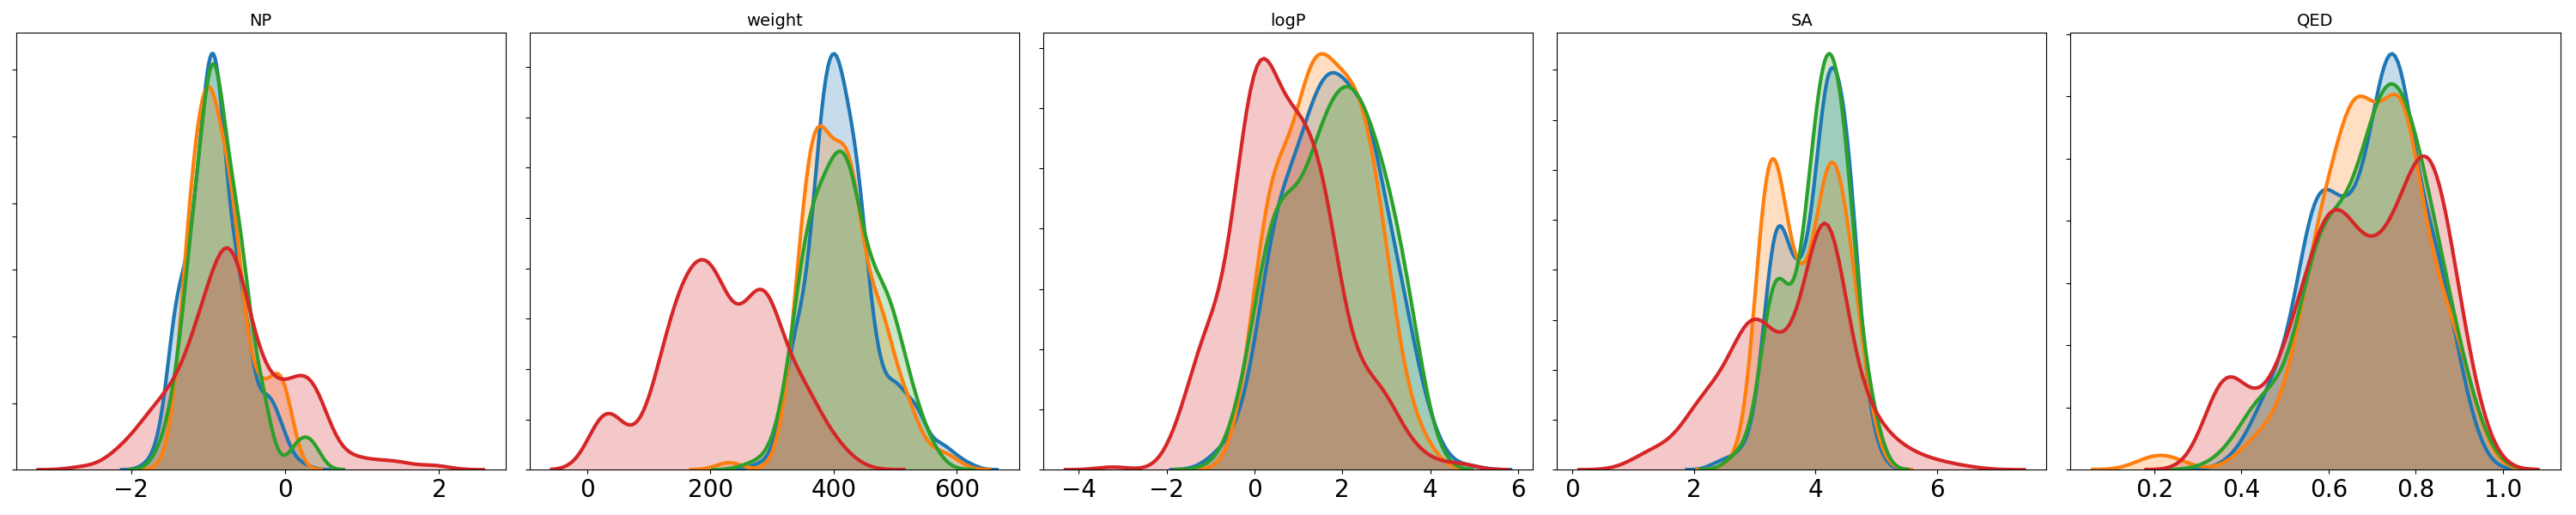

In [42]:
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
names = ['aae','char_rnn']#,'vae'
models = pd.DataFrame({'path':[os.path.join(MOSES_DIR,name+'_generated.smi') for name in names],
                       'name':['AAE','Char_RNN']})
model_jtnn = pd.DataFrame({'path':[os.path.join(MOSES_DIR,'JT_VAE_generated-pretrain_filt-focused-E30E30.smi')],
                          'name':['JTVAE pre-trained']})
models = pd.concat([models, model_jtnn], axis =0).reset_index()

fig = plot_distributions(models=models, test=os.path.join(MOSES_DIR,'X_test_smiles.txt'))
fig.tight_layout()
display(fig)

# unused material

In [44]:
test = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','test-183.csv'))
chemprop_preds = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x','fold_0/model_0/test_preds.csv'))
XGB_DIR = '/dbfs/FileStore/XGB-Hopt/'
lgb_preds = pd.read_csv(os.path.join(XGB_DIR,'predicts20190429.csv'))

In [45]:
MODELS = ModelsStorage()
parser = parser_train()
config = parser.parse_args(['organ',
                            '--seed', '13',
                            '--train_load',os.path.join(MOSES_DIR,'X_train_smiles.txt'),
                            '--val_load',os.path.join(MOSES_DIR,'X_test_smiles.txt'),
                            '--model_save',os.path.join(MOSES_DIR,'organ.model'),
                            '--config_save',os.path.join(MOSES_DIR,'organ.config'),
                            '--vocab_save',os.path.join(MOSES_DIR,'organ.vocab'),
                            '--log_file',os.path.join(MOSES_DIR,'organ.log'),
                            '--generator_pretrain_epochs', str(10),
                            '--discriminator_pretrain_epochs', str(10),
                            '--pg_iters', str(200),
                            '--n_workers', str(4),
                            ])
train('organ',config)

Generator training (epoch #0): 0%| | 0/23 [00:00<?, ?it/s]

Generator training (epoch #0): 0%| | 0/23 [00:00<?, ?it/s, loss=3.52, running_loss=3.52]

Generator training (epoch #0): 4%|▍ | 1/23 [00:00<00:02, 7.80it/s, loss=3.52, running_loss=3.52]

Generator training (epoch #0): 4%|▍ | 1/23 [00:00<00:02, 7.80it/s, loss=3.51, running_loss=3.52]

Generator training (epoch #0): 4%|▍ | 1/23 [00:00<00:02, 7.80it/s, loss=3.51, running_loss=3.51]

Generator training (epoch #0): 4%|▍ | 1/23 [00:00<00:02, 7.80it/s, loss=3.5, running_loss=3.51] 

Generator training (epoch #0): 4%|▍ | 1/23 [00:00<00:02, 7.80it/s, loss=3.5, running_loss=3.51]

Generator training (epoch #0): 22%|██▏ | 5/23 [00:00<00:01, 10.26it/s, loss=3.5, running_loss=3.51]

Generator training (epoch #0): 22%|██▏ | 5/23 [00:00<00:01, 10.26it/s, loss=3.49, running_loss=3.51]

Generator training (epoch #0): 22%|██▏ | 5/23 [00:00<00:01, 10.26it/s, loss=3.49, running_loss=3.5] 

Generator training (epoch #0): 22%|██▏ | 5/23 [00:00<00:01, 10.26it/s, loss=3.48, running_loss=3.5]

Generator training (epoch #0): 22%|██▏ | 5/23 [00:00<00:01, 10.26it/s, loss=3.47, running_loss=3.5]

Generator training (epoch #0): 39%|███▉ | 9/23 [00:00<00:01, 13.18it/s, loss=3.47, running_loss=3.5]

Generator training (epoch #0): 39%|███▉ | 9/23 [00:00<00:01, 13.18it/s, loss=3.47, running_loss=3.49]

Generator training (epoch #0): 39%|███▉ | 9/23 [00:00<00:01, 13.18it/s, loss=3.46, running_loss=3.49]

Generator training (epoch #0): 39%|███▉ | 9/23 [00:00<00:01, 13.18it/s, loss=3.45, running_loss=3.49]

Generator training (epoch #0): 39%|███▉ | 9/23 [00:00<00:01, 13.18it/s, loss=3.44, running_loss=3.48]

Generator training (epoch #0): 57%|█████▋ | 13/23 [00:00<00:00, 16.46it/s, loss=3.44, running_loss=3.48]

Generator training (epoch #0): 57%|█████▋ | 13/23 [00:00<00:00, 16.46it/s, loss=3.43, running_loss=3.48]

Generator training (epoch #0): 57%|█████▋ | 13/23 [00:00<00:00, 16.46it/s, loss=3.42, running_loss=3.48]

Generator training (epoch #0): 57%|█████▋ | 13/23 [00:00<00:00, 16.46it/s, loss=3.41, running_loss=3.47]

Generator training (epoch #0): 57%|█████▋ | 13/23 [00:00<00:00, 16.46it/s, loss=3.4, running_loss=3.47] 

Generator training (epoch #0): 57%|█████▋ | 13/23 [00:00<00:00, 16.46it/s, loss=3.38, running_loss=3.46]

Generator training (epoch #0): 78%|███████▊ | 18/23 [00:00<00:00, 20.14it/s, loss=3.38, running_loss=3.46]

Generator training (epoch #0): 78%|███████▊ | 18/23 [00:00<00:00, 20.14it/s, loss=3.37, running_loss=3.46]

Generator training (epoch #0): 78%|███████▊ | 18/23 [00:00<00:00, 20.14it/s, loss=3.35, running_loss=3.45]

Generator training (epoch #0): 78%|███████▊ | 18/23 [00:00<00:00, 20.14it/s, loss=3.33, running_loss=3.45]

Generator training (epoch #0): 78%|███████▊ | 18/23 [00:00<00:00, 20.14it/s, loss=3.3, running_loss=3.44] 

Generator training (epoch #0): 78%|███████▊ | 18/23 [00:00<00:00, 20.14it/s, loss=3.25, running_loss=3.43]

Generator training (epoch #0): 100%|██████████| 23/23 [00:00<00:00, 23.94it/s, loss=3.25, running_loss=3.43]

Generator validation (epoch #0): 0%| | 0/6 [00:00<?, ?it/s]

Generator validation (epoch #0): 0%| | 0/6 [00:00<?, ?it/s, loss=3.22, running_loss=3.22]

Generator validation (epoch #0): 17%|█▋ | 1/6 [00:00<00:00, 8.70it/s, loss=3.22, running_loss=3.22]

Generator validation (epoch #0): 17%|█▋ | 1/6 [00:00<00:00, 8.70it/s, loss=3.21, running_loss=3.21]

Generator validation (epoch #0): 17%|█▋ | 1/6 [00:00<00:00, 8.70it/s, loss=3.22, running_loss=3.22]

Generator validation (epoch #0): 17%|█▋ | 1/6 [00:00<00:00, 8.70it/s, loss=3.22, running_loss=3.22]

Generator validation (epoch #0): 17%|█▋ | 1/6 [00:00<00:00, 8.70it/s, loss=3.21, running_loss=3.21]

Generator validation (epoch #0): 17%|█▋ | 1/6 [00:00<00:00, 8.70it/s, loss=3.22, running_loss=3.22]

Generator validation (epoch #0): 100%|██████████| 6/6 [00:00<00:00, 33.49it/s, loss=3.22, running_loss=3.22]

Generator training (epoch #1): 0%| | 0/

In [46]:

config = parser.parse_args(['organ',
                            '--seed', '13',
                            '--train_load',os.path.join(MOSES_DIR,'X_train_smiles.txt'),
                            '--val_load',os.path.join(MOSES_DIR,'X_test_smiles.txt'),
                            '--model_save',os.path.join(MOSES_DIR,'organ.model'),
                            '--config_save',os.path.join(MOSES_DIR,'organ.config'),
                            '--vocab_save',os.path.join(MOSES_DIR,'organ.vocab'),
                            '--log_file',os.path.join(MOSES_DIR,'organ.log'),
                            '--generator_pretrain_epochs', str(50),
                            '--discriminator_pretrain_epochs', str(50),
                            '--additional_rewards','qed',
                            '--pg_iters', str(100),
                            '--n_workers', str(4),
                            ])
train('organ',config)

In [47]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
MODELS = ModelsStorage()
parser = parser_train()
config = parser.parse_args(['organ',
                            '--seed', '13',
                            '--train_load',os.path.join(MOSES_DIR,'X_train_smiles.txt'),
                            '--val_load',os.path.join(MOSES_DIR,'X_test_smiles.txt'),
                            '--model_save',os.path.join(MOSES_DIR,'organ_test','organ.model'),
                            '--config_save',os.path.join(MOSES_DIR,'organ_test','organ.config'),
                            '--vocab_save',os.path.join(MOSES_DIR,'organ_test','organ.vocab'),
                            '--log_file',os.path.join(MOSES_DIR,'organ_test','organ.log'),
                            '--vocab_load',os.path.join(MOSES_DIR,'organ.vocab'),
                            '--generator_pretrain_epochs', str(0),
                            '--discriminator_pretrain_epochs', str(0),
                            '--additional_rewards','qed',
                            '--pg_iters', str(200),
                            '--n_workers', str(4),
                            ])
model = 'organ'
set_seed(config.seed)
device = torch.device(config.device)
trainer = MODELS.get_model_trainer(model)(config)
#vocab = trainer.get_vocabulary(os.path.join(MOSES_DIR,'X_train_smiles.txt'))
vocab = torch.load(os.path.join(MOSES_DIR,'organ.vocab'))
model = MODELS.get_model_class(model)(vocab, config).to(device)
val_data = read_smiles_csv(os.path.join(MOSES_DIR,'X_test_smiles.txt'))
train_data = read_smiles_csv(os.path.join(MOSES_DIR,'X_train_smiles.txt'))
load_dict = torch.load(os.path.join(MOSES_DIR,'organ.mo_000.pt'))
model.load_state_dict(load_dict)
trainer.fit(model, train_data, val_data)

In [48]:
MODELS = ModelsStorage()
parser = parser_train()
config = parser.parse_args(['aae',
                            '--seed', '13',
                            '--train_load',os.path.join(MOSES_DIR,'X_train_smiles.txt'),
                            '--val_load',os.path.join(MOSES_DIR,'X_test_smiles.txt'),
                            '--model_save',os.path.join(MOSES_DIR,'aae.model'),
                            '--config_save',os.path.join(MOSES_DIR,'aae.config'),
                            '--vocab_save',os.path.join(MOSES_DIR,'aae.vocab'),
                            '--log_file',os.path.join(MOSES_DIR,'aae.log')])
train('aae',config)

Training (epoch #0): 0%| | 0/12 [00:00<?, ?it/s]Training (epoch #0): 0%| | 0/12 [00:00<?, ?it/s, autoencoder_loss=3.51, generator_loss=0.658, discriminator_loss=0.674]Training (epoch #0): 8%|▊ | 1/12 [00:00<00:01, 9.87it/s, autoencoder_loss=3.51, generator_loss=0.658, discriminator_loss=0.674]Training (epoch #0): 8%|▊ | 1/12 [00:00<00:01, 9.87it/s, autoencoder_loss=3.49, generator_loss=0.531, discriminator_loss=0.888]Training (epoch #0): 17%|█▋ | 2/12 [00:00<00:01, 9.42it/s, autoencoder_loss=3.49, generator_loss=0.531, discriminator_loss=0.888]Training (epoch #0): 17%|█▋ | 2/12 [00:00<00:01, 9.42it/s, autoencoder_loss=3.45, generator_loss=0.592, discriminator_loss=0.742]Training (epoch #0): 25%|██▌ | 3/12 [00:00<00:00, 9.52it/s, autoencoder_loss=3.45, generator_loss=0.592, discriminator_loss=0.742]Training (epoch #0): 25%|██▌ | 3/12 [00:00<00:00, 9.52it/s, autoencoder_loss=3.38, generator_loss=0.723, discriminator_loss=0.657]Training (epoch #0): 33%|███▎ | 4/12 [00:00<00:00, 9.38it/s, autoencoder_loss=3.38, generator_loss=0.723, discriminator_loss=0.657]Training (epoch #0): 33%|███▎ | 4/12 [00:00<00:00, 9.38it/s, autoencoder_loss=3.27, generator_loss=0.964, discriminator_loss=0.619]Training (epoch #0): 33%|███▎ | 4/12 [00:00<00:00, 9.38it/s, autoencoder_loss=3.18, generator_loss=1.24, discriminator_loss=0.529] Training (epoch #0): 50%|█████ | 6/12 [00:00<00:00, 9.37it/s, autoencoder_loss=3.18, generator_loss=1.24, discriminator_loss=0.529]Training (epoch #0): 50%|█████ | 6/12 [00:00<00:00, 9.37it/s, autoencoder_loss=3.11, generator_loss=1.57, discriminator_loss=0.522]Training (epoch #0): 50%|█████ | 6/12 [00:00<00:00, 9.37it/s, autoencoder_loss=3.05, generator_loss=1.92, discriminator_loss=0.459]Training (epoch #0): 67%|██████▋ | 8/12 [00:00<00:00, 9.42it/s, autoencoder_loss=3.05, generator_loss=1.92, discriminator_loss=0.459]Training (epoch #0): 67%|██████▋ | 8/12 [00:00<00:00, 9.42it/s, autoencoder_loss=3, generator_loss=2.26, discriminator_loss=0.464] Training (epoch #0): 67%|██████▋ | 8/12 [00:01<00:00, 9.42it/s, autoencoder_loss=2.96, generator_loss=2.58, discriminator_loss=0.418]Training (epoch #0): 83%|████████▎ | 10/12 [00:01<00:00, 9.43it/s, autoencoder_loss=2.96, generator_loss=2.58, discriminator_loss=0.418]Training (epoch #0): 83%|████████▎ | 10/12 [00:01<00:00, 9.43it/s, autoencoder_loss=2.92, generator_loss=2.85, discriminator_loss=0.417]Training (epoch #0): 83%|████████▎ | 10/12 [00:01<00:00, 9.43it/s, autoencoder_loss=2.88, generator_loss=3.11, discriminator_loss=0.382]Training (epoch #0): 100%|██████████| 12/12 [00:01<00:00, 10.06it/s, autoencoder_loss=2.88, generator_loss=3.11, discriminator_loss=0.382]
Validation (epoch #0): 0%| | 0/3 [00:00<?, ?it/s]Validation (epoch #0): 0%| | 0/3 [00:00<?, ?it/s, autoencoder_loss=2.46, generator_loss=5.68, discriminator_loss=0.312]Validation (epoch #0): 0%| | 0/3 [00:00<?, ?it/s, autoencoder_loss=2.46, generator_loss=5.64, discriminator_loss=0.159]Validation (epoch #0): 0%| | 0/3 [00:00<?, ?it/s, autoencoder_loss=2.46, generator_loss=5.65, discriminator_loss=0.248]Validation (epoch #0): 100%|██████████| 3/3 [00:00<00:00, 29.65it/s, autoencoder_loss=2.46, generator_loss=5.65, discriminator_loss=0.248]
Training (epoch #1): 0%| | 0/12 [00:00<?, ?it/s]Training (epoch #1): 0%| | 0/12 [00:00<?, ?it/s, autoencoder_loss=2.47, generator_loss=5.64, discriminator_loss=0.354]Training (epoch #1): 8%|▊ | 1/12 [00:00<00:01, 9.29it/s, autoencoder_loss=2.47, generator_loss=5.64, discriminator_loss=0.354]Training (epoch #1): 8%|▊ | 1/12 [00:00<00:01, 9.29it/s, autoencoder_loss=2.45, generator_loss=5.38, discriminator_loss=0.182]Training (epoch #1): 17%|█▋ | 2/12 [00:00<00:01, 9.13it/s, autoencoder_loss=2.45, generator_loss=5.38, discriminator_loss=0.182]Training (epoch #1): 17%|█▋ | 2/12 [00:00<00:01, 9.13it/s, autoencoder_loss=2.43, generator_loss=5.16, discriminator_loss=0.21] Training (epoch #1): 17%|█▋ | 2/12 [00:00<00:01, 9.13it/s, autoencoder_loss=2.4,

In [49]:
MODELS = ModelsStorage()
parser = parser_train()
config = parser.parse_args(['char_rnn',
                            '--seed', '13',
                            '--train_load',os.path.join(MOSES_DIR,'X_train_smiles.txt'),
                            '--val_load',os.path.join(MOSES_DIR,'X_test_smiles.txt'),
                            '--model_save',os.path.join(MOSES_DIR,'char_rnn.model'),
                            '--config_save',os.path.join(MOSES_DIR,'char_rnn.config'),
                            '--vocab_save',os.path.join(MOSES_DIR,'char_rnn.vocab'),
                            '--log_file',os.path.join(MOSES_DIR,'char_rnn.log')])
train('char_rnn',config)

Training (epoch #0): 0%| | 0/23 [00:00<?, ?it/s]Training (epoch #0): 0%| | 0/23 [00:00<?, ?it/s, loss=3.52, running_loss=3.52]Training (epoch #0): 0%| | 0/23 [00:00<?, ?it/s, loss=3.47, running_loss=3.49]Training (epoch #0): 9%|▊ | 2/23 [00:00<00:01, 11.51it/s, loss=3.47, running_loss=3.49]Training (epoch #0): 9%|▊ | 2/23 [00:00<00:01, 11.51it/s, loss=3.31, running_loss=3.43]Training (epoch #0): 9%|▊ | 2/23 [00:00<00:01, 11.51it/s, loss=3.32, running_loss=3.41]Training (epoch #0): 17%|█▋ | 4/23 [00:00<00:01, 12.04it/s, loss=3.32, running_loss=3.41]Training (epoch #0): 17%|█▋ | 4/23 [00:00<00:01, 12.04it/s, loss=3, running_loss=3.32] Training (epoch #0): 17%|█▋ | 4/23 [00:00<00:01, 12.04it/s, loss=3, running_loss=3.27]Training (epoch #0): 26%|██▌ | 6/23 [00:00<00:01, 12.36it/s, loss=3, running_loss=3.27]Training (epoch #0): 26%|██▌ | 6/23 [00:00<00:01, 12.36it/s, loss=3.01, running_loss=3.23]Training (epoch #0): 26%|██▌ | 6/23 [00:00<00:01, 12.36it/s, loss=3, running_loss=3.2] Training (epoch #0): 35%|███▍ | 8/23 [00:00<00:01, 12.62it/s, loss=3, running_loss=3.2]Training (epoch #0): 35%|███▍ | 8/23 [00:00<00:01, 12.62it/s, loss=2.99, running_loss=3.18]Training (epoch #0): 35%|███▍ | 8/23 [00:00<00:01, 12.62it/s, loss=2.96, running_loss=3.16]Training (epoch #0): 43%|████▎ | 10/23 [00:00<00:01, 12.92it/s, loss=2.96, running_loss=3.16]Training (epoch #0): 43%|████▎ | 10/23 [00:00<00:01, 12.92it/s, loss=2.97, running_loss=3.14]Training (epoch #0): 43%|████▎ | 10/23 [00:00<00:01, 12.92it/s, loss=2.89, running_loss=3.12]Training (epoch #0): 52%|█████▏ | 12/23 [00:00<00:00, 13.09it/s, loss=2.89, running_loss=3.12]Training (epoch #0): 52%|█████▏ | 12/23 [00:00<00:00, 13.09it/s, loss=2.91, running_loss=3.1] Training (epoch #0): 52%|█████▏ | 12/23 [00:01<00:00, 13.09it/s, loss=2.87, running_loss=3.09]Training (epoch #0): 61%|██████ | 14/23 [00:01<00:00, 13.14it/s, loss=2.87, running_loss=3.09]Training (epoch #0): 61%|██████ | 14/23 [00:01<00:00, 13.14it/s, loss=2.85, running_loss=3.07]Training (epoch #0): 61%|██████ | 14/23 [00:01<00:00, 13.14it/s, loss=2.89, running_loss=3.06]Training (epoch #0): 70%|██████▉ | 16/23 [00:01<00:00, 13.14it/s, loss=2.89, running_loss=3.06]Training (epoch #0): 70%|██████▉ | 16/23 [00:01<00:00, 13.14it/s, loss=2.84, running_loss=3.05]Training (epoch #0): 70%|██████▉ | 16/23 [00:01<00:00, 13.14it/s, loss=2.82, running_loss=3.03]Training (epoch #0): 78%|███████▊ | 18/23 [00:01<00:00, 13.20it/s, loss=2.82, running_loss=3.03]Training (epoch #0): 78%|███████▊ | 18/23 [00:01<00:00, 13.20it/s, loss=2.8, running_loss=3.02] Training (epoch #0): 78%|███████▊ | 18/23 [00:01<00:00, 13.20it/s, loss=2.79, running_loss=3.01]Training (epoch #0): 87%|████████▋ | 20/23 [00:01<00:00, 13.32it/s, loss=2.79, running_loss=3.01]Training (epoch #0): 87%|████████▋ | 20/23 [00:01<00:00, 13.32it/s, loss=2.76, running_loss=3] Training (epoch #0): 87%|████████▋ | 20/23 [00:01<00:00, 13.32it/s, loss=2.75, running_loss=2.99]Training (epoch #0): 96%|█████████▌| 22/23 [00:01<00:00, 13.32it/s, loss=2.75, running_loss=2.99]Training (epoch #0): 96%|█████████▌| 22/23 [00:01<00:00, 13.32it/s, loss=2.71, running_loss=2.98]Training (epoch #0): 100%|██████████| 23/23 [00:01<00:00, 13.22it/s, loss=2.71, running_loss=2.98]
Validation (epoch #0): 0%| | 0/6 [00:00<?, ?it/s]Validation (epoch #0): 0%| | 0/6 [00:00<?, ?it/s, loss=2.68, running_loss=2.68]Validation (epoch #0): 0%| | 0/6 [00:00<?, ?it/s, loss=2.66, running_loss=2.67]Validation (epoch #0): 0%| | 0/6 [00:00<?, ?it/s, loss=2.68, running_loss=2.67]Validation (epoch #0): 0%| | 0/6 [00:00<?, ?it/s, loss=2.69, running_loss=2.68]Validation (epoch #0): 0%| | 0/6 [00:00<?, ?it/s, loss=2.73, running_loss=2.69]Validation (epoch #0): 0%| | 0/6 [00:00<?, ?it/s, loss=2.68, running_loss=2.69]Validation (epoch #0): 100%|██████████| 6/6 [00:00<00:00, 53.21it/s, loss=2.68, running_loss=2.69]
Training (epoch #1): 0%| | 0/23 [00:00<?, ?it/s]Training (epoch #1): 0%| | 

In [50]:
logcsv = pd.read_csv(os.path.join(MOSES_DIR,'organ.log'))
display(logcsv)

discrim-r_loss,generator_loss,loss,mode,running_loss,smoothed_reward
NaN,NaN,3.254385232925415,Pretrain: train generator,3.4317535524782925,NaN
NaN,NaN,3.221165895462036,Pretrain: eval generator,3.215540289878845,NaN
NaN,NaN,2.711377620697021,Pretrain: train generator,2.8419976027115528,NaN
NaN,NaN,2.713955402374268,Pretrain: eval generator,2.7017513116200766,NaN
NaN,NaN,2.5483102798461914,Pretrain: train generator,2.623685857524042,NaN
NaN,NaN,2.5593678951263428,Pretrain: eval generator,2.54408061504364,NaN
NaN,NaN,2.3302018642425537,Pretrain: train generator,2.4445142953292183,NaN
NaN,NaN,2.3467586040496826,Pretrain: eval generator,2.3362928231557207,NaN
NaN,NaN,2.170051097869873,Pretrain: train generator,2.240753526272981,NaN
NaN,NaN,2.163482666015625,Pretrain: eval generator,2.154156764348348,NaN


In [51]:
pre_gen_tr = logcsv[logcsv['mode']=='Pretrain: train generator']['loss']
pre_gen_tr.name = 'Pretraining loss: Generator training'
pre_gen_rl_tr = logcsv[logcsv['mode']=='Pretrain: train generator']['running_loss']
pre_gen_rl_tr.name = 'Pretraining running loss: Generator training'

pre_gen_ev = logcsv[logcsv['mode']=='Pretrain: eval generator']['loss']
pre_gen_ev.name = 'Pretraining loss: Generator validation'
pre_gen_rl_ev = logcsv[logcsv['mode']=='Pretrain: eval generator']['running_loss']
pre_gen_rl_ev.name = 'Pretraining running loss: Generator validation'


In [52]:
PG_gen = logcsv['generator_loss'].dropna().reset_index(drop=True)
PG_gen.name = 'Policy Gradient - Generator loss'
PG_dis = logcsv['discrim-r_loss'].dropna().reset_index(drop=True)
PG_dis.name = 'Policy Gradient - Discriminator loss'
PG_SR = logcsv['smoothed_reward'].dropna().reset_index(drop=True)
PG_SR.name = 'Policy Gradient - Smoothed reward'

In [53]:
plt.close()
plt.plot(pre_gen_tr,c='red')
plt.plot(pre_gen_ev,c='darkred')
plt.plot(pre_gen_rl_tr,c='blue')
plt.plot(pre_gen_rl_ev,c='darkblue')

plt.legend()
plt.title('ORGAN learning curve: Pretraining')
plt.xlabel('Epoch')
plt.ylabel('Loss')
display(plt.show())

In [54]:
plt.close()
plt.plot(PG_gen,c='red')
plt.plot(PG_dis,c='blue')
plt.plot(PG_SR,c='green')
plt.legend()
plt.title('ORGAN learning curve: Policy Gradient')
plt.xlabel('Epoch')
plt.ylabel('Loss')
display(plt.show())

In [55]:
#random stuff
MODELS = ModelsStorage()
parser = parser_train()
config = parser.parse_args(['aae','--train_load',os.path.join(MOSES_DIR,'X_train_smiles.txt'),
                            '--model_save',os.path.join(MOSES_DIR,'aae.model'),
                            '--config_save',os.path.join(MOSES_DIR,'aae.config'),
                            '--vocab_save',os.path.join(MOSES_DIR,'aae.vocab')])
model = 'aae'
set_seed(config.seed)
device = torch.device(config.device)

if config.config_save is not None:
    torch.save(config, config.config_save)

# For CUDNN to work properly
if device.type.startswith('cuda'):
    torch.cuda.set_device(device.index or 0)

train_data = read_smiles_csv(config.train_load)
if config.val_load:
    val_data = read_smiles_csv(config.val_load)
else:
    val_data = None
trainer = MODELS.get_model_trainer(model)(config)

if config.vocab_load is not None:
    assert os.path.exists(config.vocab_load), \
        'vocab_load path does not exist!'
    vocab = torch.load(config.vocab_load)
else:
    vocab = trainer.get_vocabulary(train_data)

if config.vocab_save is not None:
    torch.save(vocab, config.vocab_save)

model = MODELS.get_model_class(model)(vocab, config).to(device)

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
load_dict = torch.load(os.path.join(MOSES_DIR,'aae.mo_000.pt'))
model.load_state_dict(load_dict)
device = model.device
model.zero_grad()
criterions = {
    'autoencoder': nn.CrossEntropyLoss(),
    'generator': lambda t: -torch.mean(F.logsigmoid(t)),
    'discriminator': nn.BCEWithLogitsLoss()
}

optimizers = {
    'autoencoder': torch.optim.Adam(
        list(model.encoder.parameters()) +
        list(model.decoder.parameters()), lr=config.lr
    ),
    'generator': torch.optim.Adam(
        model.encoder.parameters(), lr=config.lr
    ),
    'discriminator': torch.optim.Adam(
        model.discriminator.parameters(), lr=config.lr
    )
}

train_loader = trainer.get_dataloader(model, train_data, shuffle=True)
tqdm_data = tqdm(train_loader,
                             desc='Training (epoch #{})'.format(10))

postfix = trainer._train_epoch(model, tqdm_data, criterions, optimizers)

0%| | 0/12 [00:00<?, ?it/s] 0%| | 0/12 [00:00<?, ?it/s, autoencoder_loss=1.61, generator_loss=3.89, discriminator_loss=0.177] 8%|▊ | 1/12 [00:00<00:01, 9.40it/s, autoencoder_loss=1.61, generator_loss=3.89, discriminator_loss=0.177] 8%|▊ | 1/12 [00:00<00:01, 9.40it/s, autoencoder_loss=2.15, generator_loss=2.95, discriminator_loss=0.317] 17%|█▋ | 2/12 [00:00<00:01, 9.12it/s, autoencoder_loss=2.15, generator_loss=2.95, discriminator_loss=0.317] 17%|█▋ | 2/12 [00:00<00:01, 9.12it/s, autoencoder_loss=2.08, generator_loss=2.12, discriminator_loss=0.244] 25%|██▌ | 3/12 [00:00<00:00, 9.15it/s, autoencoder_loss=2.08, generator_loss=2.12, discriminator_loss=0.244] 25%|██▌ | 3/12 [00:00<00:00, 9.15it/s, autoencoder_loss=2.02, generator_loss=1.63, discriminator_loss=1.61]  33%|███▎ | 4/12 [00:00<00:00, 9.10it/s, autoencoder_loss=2.02, generator_loss=1.63, discriminator_loss=1.61] 33%|███▎ | 4/12 [00:00<00:00, 9.10it/s, autoencoder_loss=1.97, generator_loss=1.38, discriminator_loss=1.32] 42%|████▏ | 5/12 [00:00<00:00, 9.26it/s, autoencoder_loss=1.97, generator_loss=1.38, discriminator_loss=1.32] 42%|████▏ | 5/12 [00:00<00:00, 9.26it/s, autoencoder_loss=1.93, generator_loss=1.25, discriminator_loss=1.69] 50%|█████ | 6/12 [00:00<00:00, 9.17it/s, autoencoder_loss=1.93, generator_loss=1.25, discriminator_loss=1.69] 50%|█████ | 6/12 [00:00<00:00, 9.17it/s, autoencoder_loss=1.89, generator_loss=1.22, discriminator_loss=1.49] 58%|█████▊ | 7/12 [00:00<00:00, 9.10it/s, autoencoder_loss=1.89, generator_loss=1.22, discriminator_loss=1.49] 58%|█████▊ | 7/12 [00:00<00:00, 9.10it/s, autoencoder_loss=1.87, generator_loss=1.19, discriminator_loss=1.71] 67%|██████▋ | 8/12 [00:00<00:00, 8.96it/s, autoencoder_loss=1.87, generator_loss=1.19, discriminator_loss=1.71] 67%|██████▋ | 8/12 [00:00<00:00, 8.96it/s, autoencoder_loss=1.85, generator_loss=1.17, discriminator_loss=1.55] 67%|██████▋ | 8/12 [00:01<00:00, 8.96it/s, autoencoder_loss=1.82, generator_loss=1.11, discriminator_loss=1.73] 83%|████████▎ | 10/12 [00:01<00:00, 9.17it/s, autoencoder_loss=1.82, generator_loss=1.11, discriminator_loss=1.73] 83%|████████▎ | 10/12 [00:01<00:00, 9.17it/s, autoencoder_loss=1.8, generator_loss=1.08, discriminator_loss=1.6]  83%|████████▎ | 10/12 [00:01<00:00, 9.17it/s, autoencoder_loss=1.78, generator_loss=1.06, discriminator_loss=1.7]100%|██████████| 12/12 [00:01<00:00, 9.84it/s, autoencoder_loss=1.78, generator_loss=1.06, discriminator_loss=1.7]

In [56]:
def run(models, additional_args = []):
  
  for i,model in enumerate(models):
    parser = parser_train()
    config = parser.parse_args([model,'--train_load',os.path.join(MOSES_DIR,'X_train_smiles.txt'),
                                      '--model_save',os.path.join(MOSES_DIR,model+'.model'),
                                      '--config_save',os.path.join(MOSES_DIR,model+'.config'),
                                      '--vocab_save',os.path.join(MOSES_DIR,model+'.vocab')]+additional_args[i])
    train(model,config)
def eval(models, n_samples = 1000, print_metrics = False):
  n_samples = str(n_samples)
  metrics=[]
  MODELS = ModelsStorage()
  for model in models:
    print("Evaluating: ",model)
    parser = parser_generate()
    config = parser.parse_args([model,'--model_load',os.path.join(MOSES_DIR,model+'.model'),
                                      '--config_load',os.path.join(MOSES_DIR,model+'.config'),
                                      '--vocab_load',os.path.join(MOSES_DIR,model+'.vocab'),
                                      '--n_samples',n_samples,
                                      '--gen_save',os.path.join(MOSES_DIR,model+'_generated.smi')])
    generate(model,config)
    parser = parser_eval()
    config = parser.parse_known_args(['--test_path',os.path.join(MOSES_DIR,'X_test_smiles.txt'),
                                      '--gen_path',os.path.join(MOSES_DIR,model+'_generated.smi')])[0]
    metrics.append(evaluate(config, print_metrics = print_metrics))
  return metrics

In [57]:
run(['aae','vae','char_rnn'],additional_args = [['--train_epochs','100'],
                                                ['--clip_grad','200'],
                                                ['--train_epochs','200']])

Training (epoch #0): 0%| | 0/12 [00:00<?, ?it/s]Training (epoch #0): 0%| | 0/12 [00:00<?, ?it/s, autoencoder_loss=3.52, generator_loss=0.723, discriminator_loss=0.73]Training (epoch #0): 8%|▊ | 1/12 [00:00<00:01, 9.35it/s, autoencoder_loss=3.52, generator_loss=0.723, discriminator_loss=0.73]Training (epoch #0): 8%|▊ | 1/12 [00:00<00:01, 9.35it/s, autoencoder_loss=3.49, generator_loss=0.573, discriminator_loss=0.898]Training (epoch #0): 17%|█▋ | 2/12 [00:00<00:01, 8.98it/s, autoencoder_loss=3.49, generator_loss=0.573, discriminator_loss=0.898]Training (epoch #0): 17%|█▋ | 2/12 [00:00<00:01, 8.98it/s, autoencoder_loss=3.45, generator_loss=0.625, discriminator_loss=0.761]Training (epoch #0): 25%|██▌ | 3/12 [00:00<00:01, 8.96it/s, autoencoder_loss=3.45, generator_loss=0.625, discriminator_loss=0.761]Training (epoch #0): 25%|██▌ | 3/12 [00:00<00:01, 8.96it/s, autoencoder_loss=3.39, generator_loss=0.751, discriminator_loss=0.672]Training (epoch #0): 33%|███▎ | 4/12 [00:00<00:00, 8.99it/s, autoencoder_loss=3.39, generator_loss=0.751, discriminator_loss=0.672]Training (epoch #0): 33%|███▎ | 4/12 [00:00<00:00, 8.99it/s, autoencoder_loss=3.29, generator_loss=0.984, discriminator_loss=0.633]Training (epoch #0): 33%|███▎ | 4/12 [00:00<00:00, 8.99it/s, autoencoder_loss=3.2, generator_loss=1.24, discriminator_loss=0.544] Training (epoch #0): 50%|█████ | 6/12 [00:00<00:00, 9.12it/s, autoencoder_loss=3.2, generator_loss=1.24, discriminator_loss=0.544]Training (epoch #0): 50%|█████ | 6/12 [00:00<00:00, 9.12it/s, autoencoder_loss=3.12, generator_loss=1.54, discriminator_loss=0.538]Training (epoch #0): 50%|█████ | 6/12 [00:00<00:00, 9.12it/s, autoencoder_loss=3.07, generator_loss=1.82, discriminator_loss=0.474]Training (epoch #0): 67%|██████▋ | 8/12 [00:00<00:00, 9.28it/s, autoencoder_loss=3.07, generator_loss=1.82, discriminator_loss=0.474]Training (epoch #0): 67%|██████▋ | 8/12 [00:00<00:00, 9.28it/s, autoencoder_loss=3.02, generator_loss=2.09, discriminator_loss=0.466]Training (epoch #0): 75%|███████▌ | 9/12 [00:00<00:00, 9.46it/s, autoencoder_loss=3.02, generator_loss=2.09, discriminator_loss=0.466]Training (epoch #0): 75%|███████▌ | 9/12 [00:01<00:00, 9.46it/s, autoencoder_loss=2.97, generator_loss=2.33, discriminator_loss=0.421]Training (epoch #0): 83%|████████▎ | 10/12 [00:01<00:00, 9.43it/s, autoencoder_loss=2.97, generator_loss=2.33, discriminator_loss=0.421]Training (epoch #0): 83%|████████▎ | 10/12 [00:01<00:00, 9.43it/s, autoencoder_loss=2.93, generator_loss=2.54, discriminator_loss=0.424]Training (epoch #0): 83%|████████▎ | 10/12 [00:01<00:00, 9.43it/s, autoencoder_loss=2.9, generator_loss=2.71, discriminator_loss=0.39] Training (epoch #0): 100%|██████████| 12/12 [00:01<00:00, 10.04it/s, autoencoder_loss=2.9, generator_loss=2.71, discriminator_loss=0.39]
Training (epoch #1): 0%| | 0/12 [00:00<?, ?it/s]Training (epoch #1): 0%| | 0/12 [00:00<?, ?it/s, autoencoder_loss=2.48, generator_loss=4.59, discriminator_loss=0.51]Training (epoch #1): 8%|▊ | 1/12 [00:00<00:01, 9.84it/s, autoencoder_loss=2.48, generator_loss=4.59, discriminator_loss=0.51]Training (epoch #1): 8%|▊ | 1/12 [00:00<00:01, 9.84it/s, autoencoder_loss=2.46, generator_loss=4.35, discriminator_loss=0.27]Training (epoch #1): 17%|█▋ | 2/12 [00:00<00:01, 9.59it/s, autoencoder_loss=2.46, generator_loss=4.35, discriminator_loss=0.27]Training (epoch #1): 17%|█▋ | 2/12 [00:00<00:01, 9.59it/s, autoencoder_loss=2.44, generator_loss=4.18, discriminator_loss=0.32]Training (epoch #1): 17%|█▋ | 2/12 [00:00<00:01, 9.59it/s, autoencoder_loss=2.43, generator_loss=3.94, discriminator_loss=0.259]Training (epoch #1): 33%|███▎ | 4/12 [00:00<00:00, 9.60it/s, autoencoder_loss=2.43, generator_loss=3.94, discriminator_loss=0.259]Training (epoch #1): 33%|███▎ | 4/12 [00:00<00:00, 9.60it/s, autoencoder_loss=2.42, generator_loss=3.76, discriminator_loss=0.274]Training (epoch #1): 33%|███▎ | 4/12 [00:00<00:00, 9.60it/s, autoencoder_loss=2.4, generator_loss=3.56, discrimin

In [58]:
metrics_all = eval(['aae','char_rnn'],n_samples=200)#,'vae'

Evaluating: aae
Generating samples: 0%| | 0/200 [00:00<?, ?it/s]Generating samples: 16%|█▌ | 32/200 [00:00<00:00, 262.28it/s]Generating samples: 32%|███▏ | 64/200 [00:00<00:00, 264.40it/s]Generating samples: 48%|████▊ | 96/200 [00:00<00:00, 265.96it/s]Generating samples: 64%|██████▍ | 128/200 [00:00<00:00, 267.23it/s]Generating samples: 80%|████████ | 160/200 [00:00<00:00, 267.38it/s]Generating samples: 96%|█████████▌| 192/200 [00:00<00:00, 267.98it/s]Generating samples: 100%|██████████| 200/200 [00:00<00:00, 240.20it/s]
/databricks/python/lib/python3.6/site-packages/moses/metrics/metrics.py:194: UserWarning: Can't compute unique@1000.gen contains only 136 molecules
 "gen contains only {} molecules".format(len(gen))
/databricks/python/lib/python3.6/site-packages/moses/metrics/metrics.py:194: UserWarning: Can't compute unique@10000.gen contains only 136 molecules
 "gen contains only {} molecules".format(len(gen))
Evaluating: char_rnn
Generating samples: 0%| | 0/200 [00:00<?, ?it/s]Generating samples: 16%|█▌ | 32/200 [00:00<00:01, 93.10it/s]Generating samples: 32%|███▏ | 64/200 [00:00<00:01, 92.75it/s]Generating samples: 48%|████▊ | 96/200 [00:01<00:01, 93.40it/s]Generating samples: 64%|██████▍ | 128/200 [00:01<00:00, 93.34it/s]Generating samples: 80%|████████ | 160/200 [00:01<00:00, 93.61it/s]Generating samples: 96%|█████████▌| 192/200 [00:02<00:00, 93.89it/s]Generating samples: 100%|██████████| 200/200 [00:02<00:00, 90.93it/s]
/databricks/python/lib/python3.6/site-packages/moses/metrics/metrics.py:194: UserWarning: Can't compute unique@1000.gen contains only 146 molecules
 "gen contains only {} molecules".format(len(gen))
/databricks/python/lib/python3.6/site-packages/moses/metrics/metrics.py:194: UserWarning: Can't compute unique@10000.gen contains only 146 molecules
 "gen contains only {} molecules".format(len(gen))

In [59]:
import pickle
pickle.dump(metrics_all, open(os.path.join(MOSES_DIR,'metrics20190411.p'),'wb'))